# Predicting Bundesliga Match Results

In this project, we'll use Bundesliga match logs to build a model on predicting the winner of a match. We have scraped data from [https://fbref.com](https://fbref.com) and created a csv file in a separate notebook.

Our data spans six full seasons. We'll consider k-nearest neighbors and random forests for our model, and compare their performances on our data set.

## Cleaning the data set

In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('match_data.csv')
df.shape

(3672, 40)

In [3]:
df.head()

,Unnamed: 0,date,time,round,day,venue,result,gf,ga,opponent,...,prgdist,live,dead,tb,sw,crs,ti,ck,season,team
0,1,2022-08-05,20:30,Matchweek 1,Fri,Away,W,6,1,Eint Frankfurt,...,3374.0,623.0,35.0,7.0,4.0,14.0,11.0,6.0,2022-2023,Bayern Munich
1,2,2022-08-14,17:30,Matchweek 2,Sun,Home,W,2,0,Wolfsburg,...,3508.0,592.0,50.0,1.0,5.0,20.0,23.0,8.0,2022-2023,Bayern Munich
2,3,2022-08-21,17:30,Matchweek 3,Sun,Away,W,7,0,Bochum,...,3056.0,498.0,42.0,3.0,2.0,10.0,16.0,5.0,2022-2023,Bayern Munich
3,4,2022-08-27,18:30,Matchweek 4,Sat,Home,D,1,1,M'Gladbach,...,3614.0,621.0,47.0,1.0,7.0,33.0,20.0,14.0,2022-2023,Bayern Munich
4,6,2022-09-03,15:30,Matchweek 5,Sat,Away,D,1,1,Union Berlin,...,3464.0,710.0,50.0,6.0,2.0,17.0,17.0,7.0,2022-2023,Bayern Munich


In [4]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
# Check if there are any missing matches
df['round'].value_counts().sort_values()

Matchweek 1     108
Matchweek 4     108
Matchweek 5     108
Matchweek 6     108
Matchweek 7     108
Matchweek 8     108
Matchweek 9     108
Matchweek 10    108
Matchweek 11    108
Matchweek 12    108
Matchweek 13    108
Matchweek 14    108
Matchweek 15    108
Matchweek 16    108
Matchweek 17    108
Matchweek 18    108
Matchweek 19    108
Matchweek 33    108
Matchweek 26    108
Matchweek 20    108
Matchweek 21    108
Matchweek 22    108
Matchweek 23    108
Matchweek 24    108
Matchweek 3     108
Matchweek 25    108
Matchweek 2     108
Matchweek 28    108
Matchweek 29    108
Matchweek 30    108
Matchweek 31    108
Matchweek 32    108
Matchweek 27    108
Matchweek 34    108
Name: round, dtype: int64

In [6]:
df['date'] = pd.to_datetime(df['date'])

In [7]:
pd.set_option('display.max_columns', None)
df.head()

,date,time,round,day,venue,result,gf,ga,opponent,xg,xga,poss,attendance,captain,formation,referee,sh,sot,dist,fk,pk,pkatt,sota,saves,pka,pksv,cmp,att,totdist,prgdist,live,dead,tb,sw,crs,ti,ck,season,team
0,2022-08-05,20:30,Matchweek 1,Fri,Away,W,6,1,Eint Frankfurt,4.0,0.9,63.0,51500.0,Manuel Neuer,4-4-2,Deniz Aytekin,23.0,10.0,16.6,1.0,0.0,0.0,2.0,1.0,0.0,0.0,572.0,661.0,10072.0,3374.0,623.0,35.0,7.0,4.0,14.0,11.0,6.0,2022-2023,Bayern Munich
1,2022-08-14,17:30,Matchweek 2,Sun,Home,W,2,0,Wolfsburg,2.0,0.5,68.0,75000.0,Manuel Neuer,4-2-3-1,Harm Osmers,24.0,8.0,18.4,0.0,0.0,0.0,2.0,2.0,0.0,0.0,549.0,648.0,9680.0,3508.0,592.0,50.0,1.0,5.0,20.0,23.0,8.0,2022-2023,Bayern Munich
2,2022-08-21,17:30,Matchweek 3,Sun,Away,W,7,0,Bochum,2.9,0.7,64.0,26000.0,Manuel Neuer,4-4-2,Daniel Siebert,21.0,11.0,18.3,1.0,1.0,1.0,7.0,7.0,0.0,0.0,462.0,545.0,7943.0,3056.0,498.0,42.0,3.0,2.0,10.0,16.0,5.0,2022-2023,Bayern Munich
3,2022-08-27,18:30,Matchweek 4,Sat,Home,D,1,1,M'Gladbach,2.8,0.5,69.0,75000.0,Manuel Neuer,4-2-2-2,Daniel Schlager,33.0,20.0,17.4,1.0,0.0,0.0,3.0,2.0,0.0,0.0,576.0,675.0,9943.0,3614.0,621.0,47.0,1.0,7.0,33.0,20.0,14.0,2022-2023,Bayern Munich
4,2022-09-03,15:30,Matchweek 5,Sat,Away,D,1,1,Union Berlin,1.5,0.3,74.0,22012.0,Manuel Neuer,4-2-3-1,Frank Willenborg,21.0,6.0,18.1,0.0,0.0,0.0,2.0,1.0,0.0,0.0,657.0,762.0,10395.0,3464.0,710.0,50.0,6.0,2.0,17.0,17.0,7.0,2022-2023,Bayern Munich


There are inconsistencies in the team names in `team` and `opponent` columns; below we look at the different occurences of the same team, and standardize the names.

In [8]:
team_set = set(df['team'].unique())
opp_set = set(df['opponent'].unique())

diff = (team_set - opp_set) | (opp_set - team_set)
diff


{'Bayer Leverkusen',
 'Dusseldorf',
 'Düsseldorf',
 'Eint Frankfurt',
 'Eintracht Frankfurt',
 'Greuther Furth',
 'Greuther Fürth',
 'Koln',
 'Köln',
 'Leverkusen',
 "M'Gladbach",
 'Monchengladbach',
 'Nurnberg',
 'Nürnberg'}

In [9]:
class MissingDict(dict):
    __missing__ = lambda self, key: key

map_values = {
    'Koln':'Köln',
    'Leverkusen': 'Bayer Leverkusen',
    'Dusseldorf': 'Düsseldorf',
    'Eint Frankfurt': 'Eintracht Frankfurt',
    'Greuther Furth': 'Greuther Fürth',
    "M'Gladbach": 'Monchengladbach',
    'Nurnberg': 'Nürnberg'
}

mapping = MissingDict(**map_values)

In [10]:
df['team'] = df['team'].map(mapping)

In [11]:
df['opponent'] = df['opponent'].map(mapping)

We need to take care of null values in order to use most machine learning models. Below we observe that the `attendance` column has a lot of null values. We remove this column altogether since it is not necessary for our purposes. We also observe that all other null values appear in three rows, which we also remove.

In [12]:
df.isna().sum().sort_values(ascending=False)

attendance    744
dist            3
fk              2
xg              2
cmp             2
att             2
totdist         2
prgdist         2
live            2
xga             2
dead            2
tb              2
sw              2
ti              2
ck              2
sota            0
crs             0
pksv            0
season          0
pka             0
saves           0
date            0
pkatt           0
opponent        0
round           0
day             0
venue           0
result          0
gf              0
ga              0
poss            0
pk              0
captain         0
formation       0
referee         0
sh              0
sot             0
time            0
team            0
dtype: int64

In [13]:
df.drop('attendance', axis=1, inplace=True)

In [14]:
df[df['dist'].isna()]

,date,time,round,day,venue,result,gf,ga,opponent,xg,xga,poss,captain,formation,referee,sh,sot,dist,fk,pk,pkatt,sota,saves,pka,pksv,cmp,att,totdist,prgdist,live,dead,tb,sw,crs,ti,ck,season,team
944,2022-03-18,20:30,Matchweek 27,Fri,Away,W,2,0,Bochum,NaN,NaN,49.0,Yann Sommer,3-4-3,Benjamin Cortus,8.0,5.0,NaN,NaN,0.0,0.0,7.0,7.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,2021-2022,Monchengladbach
1046,2022-03-18,20:30,Matchweek 27,Fri,Home,L,0,2,Monchengladbach,NaN,NaN,51.0,Anthony Losilla,4-3-3,Benjamin Cortus,16.0,7.0,NaN,NaN,0.0,0.0,5.0,3.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,2021-2022,Bochum
1707,2020-11-21,15:30,Matchweek 8,Sat,Home,L,1,2,Bayer Leverkusen,0.0,1.2,31.0,Fabian Klos,4-1-4-1,Felix Brych,0.0,0.0,NaN,0.0,0.0,0.0,4.0,2.0,0.0,0.0,239.0,365.0,4896.0,2155.0,326.0,36.0,0.0,1.0,9.0,18.0,0.0,2020-2021,Arminia


In [15]:
df.drop(df[df['dist'].isna()].index, inplace=True)


In [16]:
# Check total number of null values
df.isna().sum().sum()

0

## Selecting features

The values in our target column consist of three categories: W(in), D(raw), and L(ose). We'll simplify our target into two categories corresponding to whether the team has won or not.

In [17]:
df['target'] = (df['result'] == 'W').astype(int)

In [18]:
df['target'].value_counts()

0    2287
1    1382
Name: target, dtype: int64

There are several columns containing categorical data that are relevant for our purposes. Below we encode these columns into a numerical format. We also simplify a couple of time related columns.

In [19]:
df['venue_code'] = (df['venue'] == 'Home').astype(int)

In [20]:
df['opp_code'] = df['opponent'].astype('category').cat.codes

In [21]:
df['hour'] = df['time'].str.replace(r":.+", '', regex=True).astype(int)

In [22]:
df['day_code'] = df['date'].dt.dayofweek

In [23]:
df.head()

,date,time,round,day,venue,result,gf,ga,opponent,xg,xga,poss,captain,formation,referee,sh,sot,dist,fk,pk,pkatt,sota,saves,pka,pksv,cmp,att,totdist,prgdist,live,dead,tb,sw,crs,ti,ck,season,team,target,venue_code,opp_code,hour,day_code
0,2022-08-05,20:30,Matchweek 1,Fri,Away,W,6,1,Eintracht Frankfurt,4.0,0.9,63.0,Manuel Neuer,4-4-2,Deniz Aytekin,23.0,10.0,16.6,1.0,0.0,0.0,2.0,1.0,0.0,0.0,572.0,661.0,10072.0,3374.0,623.0,35.0,7.0,4.0,14.0,11.0,6.0,2022-2023,Bayern Munich,1,0,7,20,4
1,2022-08-14,17:30,Matchweek 2,Sun,Home,W,2,0,Wolfsburg,2.0,0.5,68.0,Manuel Neuer,4-2-3-1,Harm Osmers,24.0,8.0,18.4,0.0,0.0,0.0,2.0,2.0,0.0,0.0,549.0,648.0,9680.0,3508.0,592.0,50.0,1.0,5.0,20.0,23.0,8.0,2022-2023,Bayern Munich,1,1,24,17,6
2,2022-08-21,17:30,Matchweek 3,Sun,Away,W,7,0,Bochum,2.9,0.7,64.0,Manuel Neuer,4-4-2,Daniel Siebert,21.0,11.0,18.3,1.0,1.0,1.0,7.0,7.0,0.0,0.0,462.0,545.0,7943.0,3056.0,498.0,42.0,3.0,2.0,10.0,16.0,5.0,2022-2023,Bayern Munich,1,0,4,17,6
3,2022-08-27,18:30,Matchweek 4,Sat,Home,D,1,1,Monchengladbach,2.8,0.5,69.0,Manuel Neuer,4-2-2-2,Daniel Schlager,33.0,20.0,17.4,1.0,0.0,0.0,3.0,2.0,0.0,0.0,576.0,675.0,9943.0,3614.0,621.0,47.0,1.0,7.0,33.0,20.0,14.0,2022-2023,Bayern Munich,0,1,16,18,5
4,2022-09-03,15:30,Matchweek 5,Sat,Away,D,1,1,Union Berlin,1.5,0.3,74.0,Manuel Neuer,4-2-3-1,Frank Willenborg,21.0,6.0,18.1,0.0,0.0,0.0,2.0,1.0,0.0,0.0,657.0,762.0,10395.0,3464.0,710.0,50.0,6.0,2.0,17.0,17.0,7.0,2022-2023,Bayern Munich,0,0,22,15,5


## Models

Our dataframe includes nominal data, such as `venue_code` and `opp_code`, and consequently we would like to try models that are suitable for nonlinear behavior. We'll try and compare k-nearest neighbors classifier and random forest classifier on our data set.

Initially, we'll use the four columns we created above as predictors. Later on we'll compute rolling averages additional features.

In [24]:
initial_predictors = ['venue_code', 'opp_code', 'hour', 'day_code']

In [25]:
def model_report(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(classification_report(y_test, preds))

    combined = pd.DataFrame({'actual':y_test, 'predicted':preds})
    return pd.crosstab(index=combined['actual'], columns=combined['predicted'])

Our data is time dependent, and hence not suitable for random cross validation. We'll separate the 2022-2023 season as our test set, and use the previous seasons as our training set.

In [26]:
train = df[df['date'] < '2022-07-01']
test = df[df['date'] > '2022-07-01']

### K-nearest neighors

In [27]:
scaler= MinMaxScaler()
X_train = scaler.fit_transform(train[initial_predictors], train['target'])
X_test = scaler.transform(test[initial_predictors])

knn = KNeighborsClassifier(n_neighbors=3)

model_report(X_train, X_test, train['target'], test['target'], knn)

              precision    recall  f1-score   support

           0       0.67      0.70      0.69       381
           1       0.47      0.44      0.45       231

    accuracy                           0.60       612
   macro avg       0.57      0.57      0.57       612
weighted avg       0.60      0.60      0.60       612



/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


predicted,0,1
actual,,
0,267,114
1,130,101


### Random forest

In [28]:
rf = RandomForestClassifier(n_estimators=50,
                            min_samples_split=10,
                            random_state=1)

model_report(train[initial_predictors],test[initial_predictors],
             train['target'], test['target'], rf)

              precision    recall  f1-score   support

           0       0.65      0.83      0.73       381
           1       0.48      0.26      0.33       231

    accuracy                           0.62       612
   macro avg       0.57      0.55      0.53       612
weighted avg       0.59      0.62      0.58       612



predicted,0,1
actual,,
0,318,63
1,172,59


KNN's f1-score on positive predictions is better than random forests, whereas random forest seems to be doing better on negative predictions.



## Using rolling averages

Next we'll compute rolling averages for several numerical features and see if these additional predictors improve our models. For each team, we will take averages over the last three matches.

In [29]:
def rolling_avg(group, cols, new_cols):
    group.sort_values('date', inplace=True)
    group[new_cols] = group[cols].rolling(4, closed='left').mean()
    group.dropna(subset=new_cols, inplace=True)
    return group

In [30]:
cols = ['sh', 'sot', 'dist', 'fk', 'pk', 'pkatt', 'sota', 'saves', 'pka',
       'pksv', 'cmp', 'att', 'totdist', 'prgdist', 'live', 'dead', 'tb', 'sw',
       'crs', 'ti', 'ck']

new_cols = [f"{c}_ravg" for c in cols]

In [31]:
df_ravg = df.groupby('team', group_keys=False) \
    .apply(lambda g: rolling_avg(g, cols, new_cols))

In [32]:
predictors = initial_predictors + new_cols

In [33]:
train = df_ravg[df_ravg['date'] < '2022-07-01']
test = df_ravg[df_ravg['date'] > '2022-07-01']

### K-nearest neighbors

In [34]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train[predictors])
X_test = scaler.transform(test[predictors])

model_report(X_train, X_test, train['target'], test['target'], knn)

              precision    recall  f1-score   support

           0       0.66      0.74      0.70       381
           1       0.46      0.36      0.40       231

    accuracy                           0.60       612
   macro avg       0.56      0.55      0.55       612
weighted avg       0.58      0.60      0.58       612



/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


predicted,0,1
actual,,
0,282,99
1,148,83


### Random forest

In [35]:
model_report(train[predictors], test[predictors],
             train['target'], test['target'], rf)

              precision    recall  f1-score   support

           0       0.66      0.90      0.76       381
           1       0.59      0.24      0.34       231

    accuracy                           0.65       612
   macro avg       0.63      0.57      0.55       612
weighted avg       0.63      0.65      0.60       612



predicted,0,1
actual,,
0,342,39
1,175,56


New predictors seem to improve performnces for both models, but the weaknesses from before are still here.

## Feature importances

In order to improve the performance of the random forest model on our data set, we'll consider which features are more important.

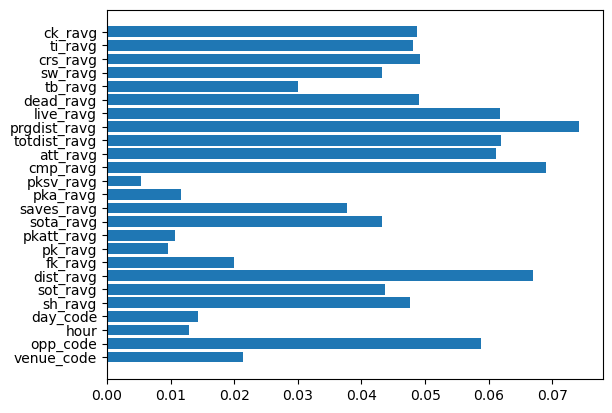

In [36]:
plt.barh(rf.feature_names_in_, rf.feature_importances_)
plt.show()

In [37]:
features = pd.DataFrame({'names': rf.feature_names_in_, 'importance': rf.feature_importances_})

In [38]:
new_predictors = features[features['importance'] > 0.035]['names']
new_predictors = list(new_predictors)
new_predictors

['opp_code',
 'sh_ravg',
 'sot_ravg',
 'dist_ravg',
 'sota_ravg',
 'saves_ravg',
 'cmp_ravg',
 'att_ravg',
 'totdist_ravg',
 'prgdist_ravg',
 'live_ravg',
 'dead_ravg',
 'sw_ravg',
 'crs_ravg',
 'ti_ravg',
 'ck_ravg']

In [39]:
rf = RandomForestClassifier(n_estimators=50,
                            min_samples_split=10,
                            random_state=1)

model_report(train[new_predictors], test[new_predictors],
             train['target'], test['target'], rf)

              precision    recall  f1-score   support

           0       0.66      0.88      0.76       381
           1       0.58      0.26      0.36       231

    accuracy                           0.65       612
   macro avg       0.62      0.57      0.56       612
weighted avg       0.63      0.65      0.61       612



predicted,0,1
actual,,
0,337,44
1,171,60


## Conclusion

We were able to improve the performance of our random forest model, especially the accuracy and precision, but recall values are still not very good. The positive predictions of this model are not as reliable as its negative predictions.

The accuracy and precision of our k-nearest neighbors model is not as good as the random forest model, but it seems to perform in a more balanced manner, which is reflected in its f-1 scores.